In [695]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

%matplotlib inline

In [696]:
dataset_path = os.path.join('.', 'datasets', 'NBA_Players.csv')

nba = pd.read_csv(dataset_path)

In [697]:
nba.head()

,TEAM,NAME,EXPERIENCE,URL,POSITION,AGE,HT,WT,COLLEGE,SALARY,...,FGP,THM_THA,THP,FTM_FTA,FTP,APG,BLKPG,STLPG,TOPG,PPG
0,Boston Celtics,Aron Baynes,6,http://www.espn.com/nba/player/_/id/2968439,SF,31,208.28,117.65,Washington State,"5,193,600",...,0.502,0.0-0.1,0.143,1.0-1.3,0.802,0.7,0.5,0.2,0.8,5.4
1,Boston Celtics,Justin Bibbs,0,http://www.espn.com/nba/player/_/id/3147500,G,22,195.58,99.55,Virginia Tech,Not signed,...,0.000,0,0.000,0,0.000,0.0,0.0,0.0,0.0,0.0
2,Boston Celtics,Jabari Bird,1,http://www.espn.com/nba/player/_/id/3064308,SG,24,198.12,89.59,California,"1,349,464",...,0.577,0.2-0.5,0.429,0.5-1.0,0.462,0.6,0.1,0.2,0.6,3.0
3,Boston Celtics,Jaylen Brown,2,http://www.espn.com/nba/player/_/id/3917376,F,21,200.66,99.55,California,"5,169,960",...,0.461,1.1-3.0,0.379,1.6-2.4,0.658,1.2,0.3,0.7,1.3,10.4
4,Boston Celtics,PJ Dozier,1,http://www.espn.com/nba/player/_/id/3923250,PG,21,198.12,92.76,South Carolina,Not signed,...,0.500,0.0-0.0,0.000,0.0-0.0,0.000,0.0,0.0,0.0,0.5,1.0


In [698]:
def fix_columns_name(df):
    # Corrigindo. Tirando os espaços no nome das colunas
    # Aproveitei para colocar as colunas em minúsculo
    df.columns = [c.strip().lower() for c in df.columns]
    return df
   
def clean_data(df):
    # "age" -> tem um bug do -
    # Vamos trocar - por 0
    df['age'] = df['age'].str.replace('-', '0').astype(int)

    # "college" -> quem tiver "-" é porque pode ser estrangeiro,
    # veio direto do ensino médio (LeBron James), não chegou a cursar faculdade
    # ou por falta informação na coleta
    df['college'] = df['college'].str.replace('-', 'ND')

    # Temos 2 problemas:
    # 1) Not Signed não é um float
    # 2) Salário com ","
    df['salary'] = df['salary'].str.replace('Not signed', '0')
    df['salary'] = df['salary'].str.replace(',', '').astype(float).apply(lambda x: x / 1000000)
    
    return df

# Remover jogadores que não tiveram salário e nem jogaram uma partida
def remove_players_no_games_salary(df):
    idxs = df[(df['gp'] == 0) & (df['salary'] == 0)].index
    df.drop(idxs, axis=0, inplace=True)

## Clean Data

In [699]:
nba = clean_data(fix_columns_name(nba))

remove_players_no_games_salary(nba)

In [700]:
nba['exp_cat'] = pd.cut(nba['experience'] / 5, 
                        bins=[-np.inf, 1, 2, 3, np.Inf], 
                        labels=['0-5', '6-10', '11-15', '16+'])

In [701]:
def top_college_chart(df, total=15): 
    order = df['college'].value_counts(ascending=False).iloc[:total].index.tolist()
    fig, _ = plt.subplots(figsize=((10, 5)))
    
    g = sns.countplot('college', data=df, order=order)
    g.set_xlabel('Universidade')
    g.set_ylabel('Quantidade')
    
    for p in g.patches:
        points = p.get_bbox().get_points()
        x = sum(points[:, 0]) / 2
        y = points[1,1]
        label = '{:.1f}%'.format((y / len(df)) * 100)

        g.annotate(label, (x, y), ha='center', va='bottom')

    g.set_title(f'Top {total} Universidades')
    fig.autofmt_xdate(rotation=45)

In [702]:
def exp_pie_chart(df):
    labels = [c + ' anos' for c in df['exp_cat'].cat.categories.tolist()]
    values = df['exp_cat'].value_counts().tolist()
    explode = (0, 0, 0.1, 0.2)
    
    fig, ax = plt.subplots(figsize=(5, 5))
    _,_, autotexts = ax.pie(values, labels=labels, explode=explode,
           autopct='%1.1f%%', startangle=90,
           labeldistance=1.05, pctdistance=.55)
    ax.axis('equal')
    
    plt.title('Divisão por Quantidade de Temporadas')
    
    for autotext in autotexts:
        autotext.set_color('white')

In [703]:
def pos_pie_chart(df):
    counts = df['position'].value_counts()
    labels = counts.keys().tolist()
    values = s.tolist()
    explode = (0, 0, 0, 0, 0, 0.2, 0.3)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    _,_,autotexts = ax.pie(values, labels=labels,
           autopct='%1.1f%%', startangle=0,
           explode=explode,
           labeldistance=1.05, pctdistance=.75)
    
    plt.title('Divisão por Posição')
    
    for autotext in autotexts:
        autotext.set_color('white')

In [704]:
def salary_sum_chart(df):
    team_salary = df.groupby('team')['salary'].sum().sort_values(ascending=False)
    labels = team_salary.index.tolist()
    values = team_salary.values / 1000000
    salary_mean = np.mean(values)
    colors = ['#4C9900' if v > salary_mean else '#CC0000' for v in values]

    fig, _ = plt.subplots(figsize=(20, 8))
    ax = sns.barplot(x=labels, y=values, palette=colors)
    
    ax.set_title('Salário Total por Time', size=20)
    ax.set_xlabel('Time', size=14)
    ax.set_ylabel('Salário (Milhões)', size=14)
    
    ax.axhline(salary_mean, color='blue', linewidth=.8, label='Média de Salário por Ano')
    ax.legend()
    
    for p in g.patches:
        points = p.get_bbox().get_points()
        x = sum(points[:, 0]) / 2
        y = points[1, 1]
        label = '${:.1f} M'.format(y)
        
        ax.annotate(label, (x, y), ha='center', va='bottom')
    
    fig.autofmt_xdate(rotation=45)

In [705]:
def stats_grouped_by_position_chart(df, attr, attr_name, kind, kind_name):
    g = sns.relplot(attr, y=kind, 
                col='position', col_wrap=3,
                hue='exp_cat', size='exp_cat',
                legend='full',
                data=df)
 
    plt.subplots_adjust(top=0.90)
    
    g.fig.suptitle(f'Média de {attr_name} por {kind_name} - Agrupado por Posição', size=22)
    g.set_axis_labels(attr_name, kind_name)

In [706]:
top10 = nba['salary'].sort_values(ascending=False)[:10].index

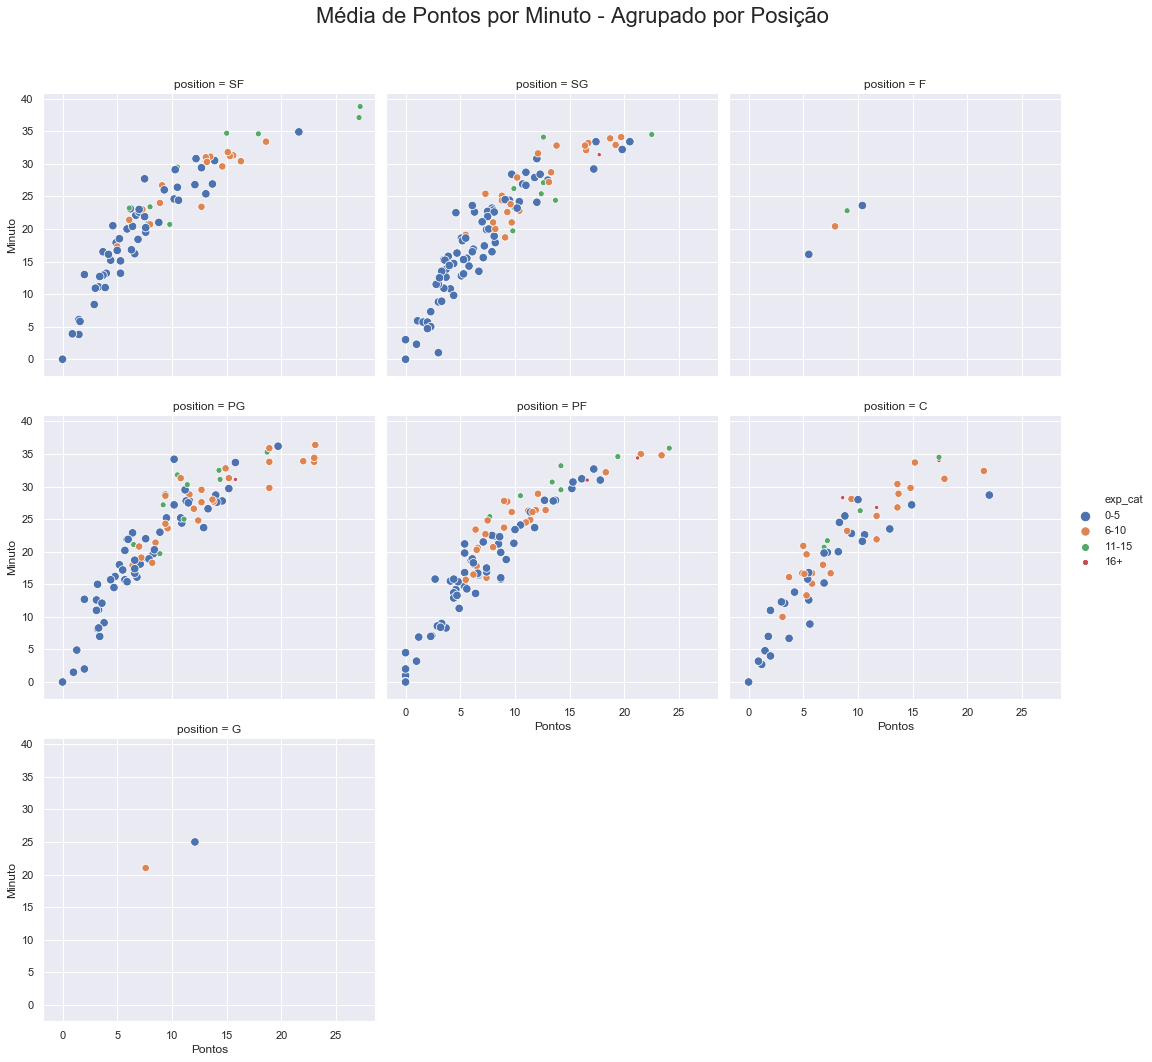

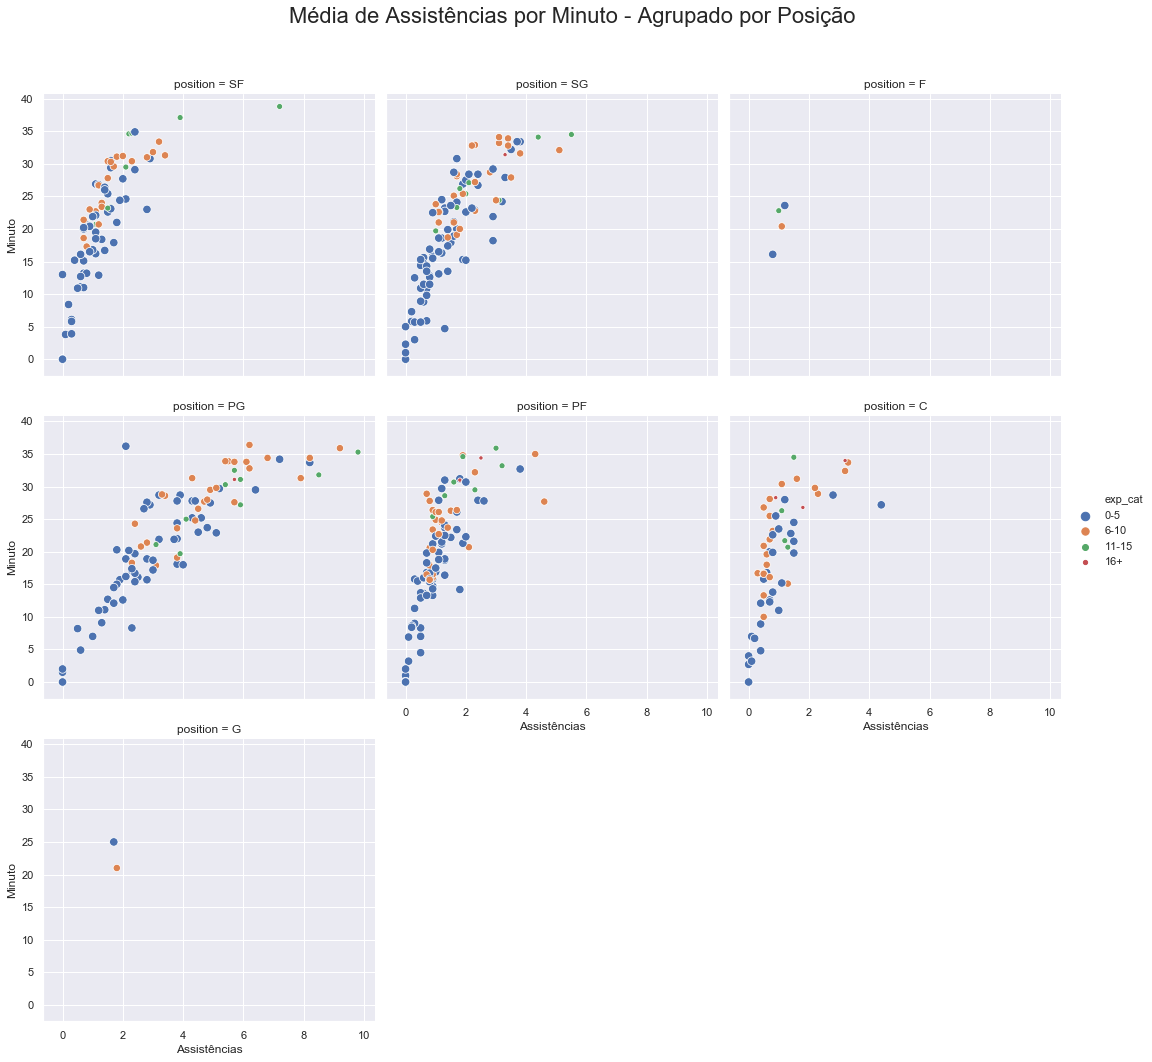

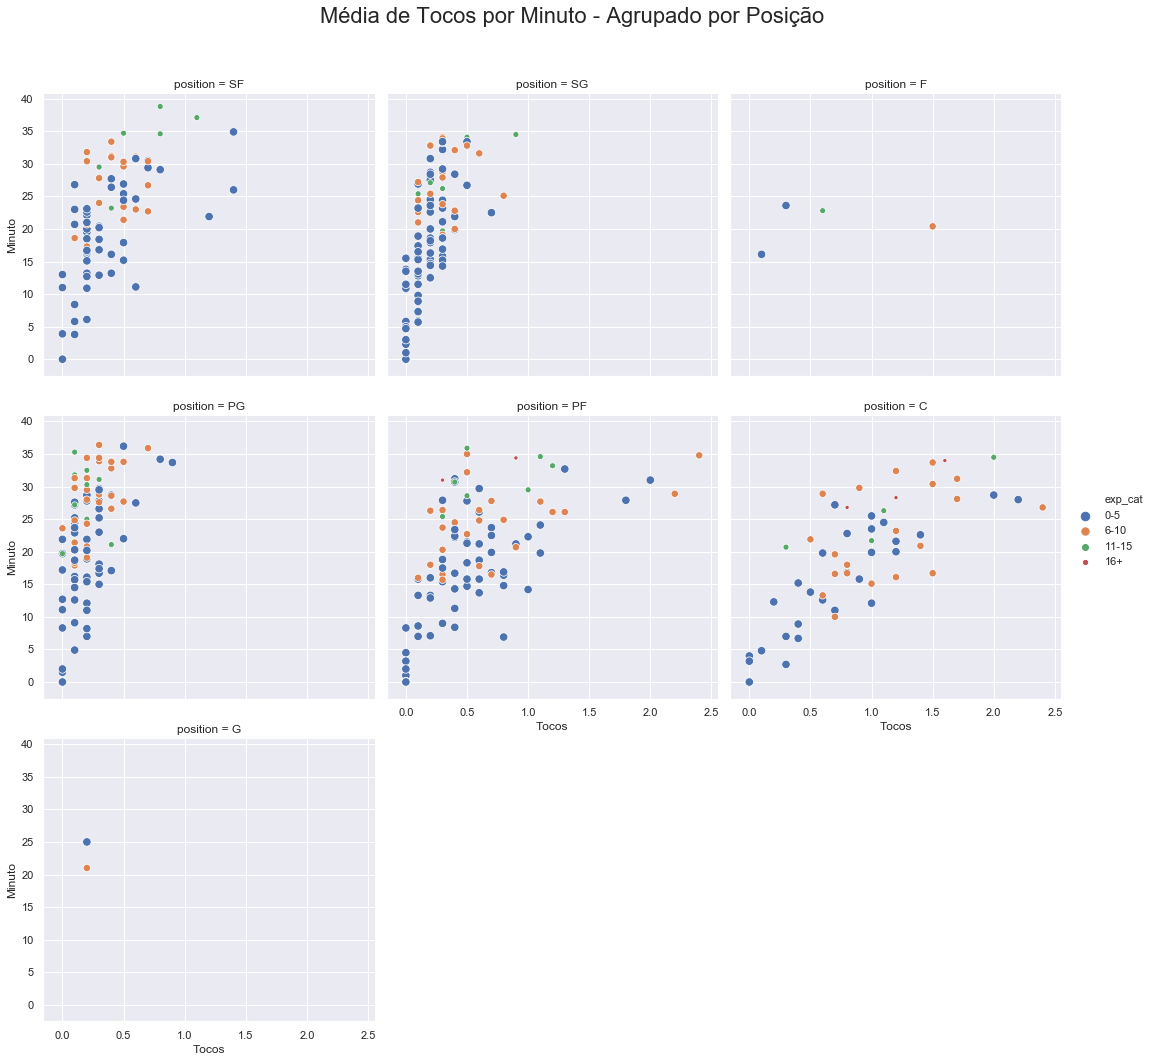

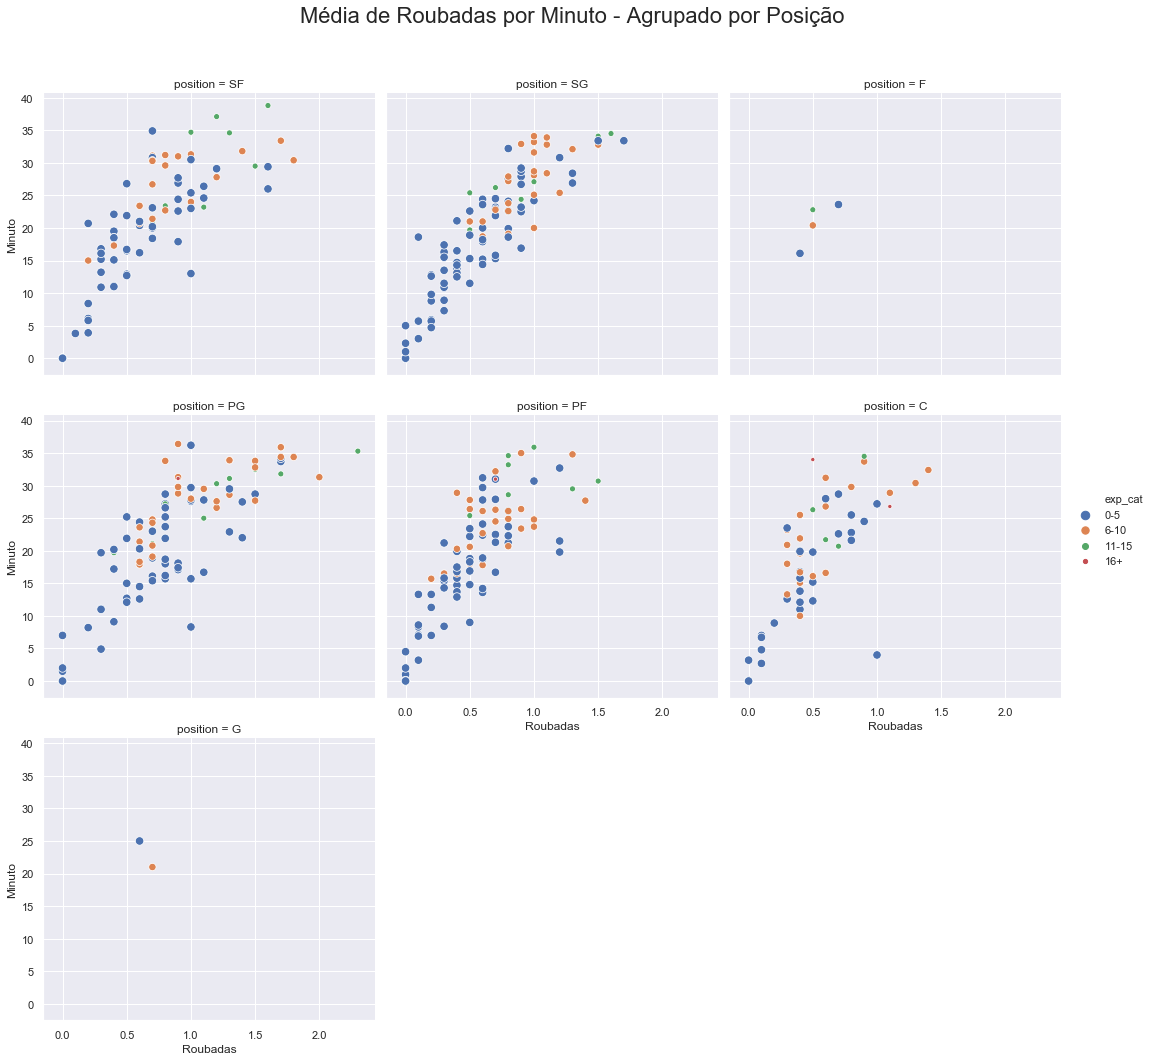

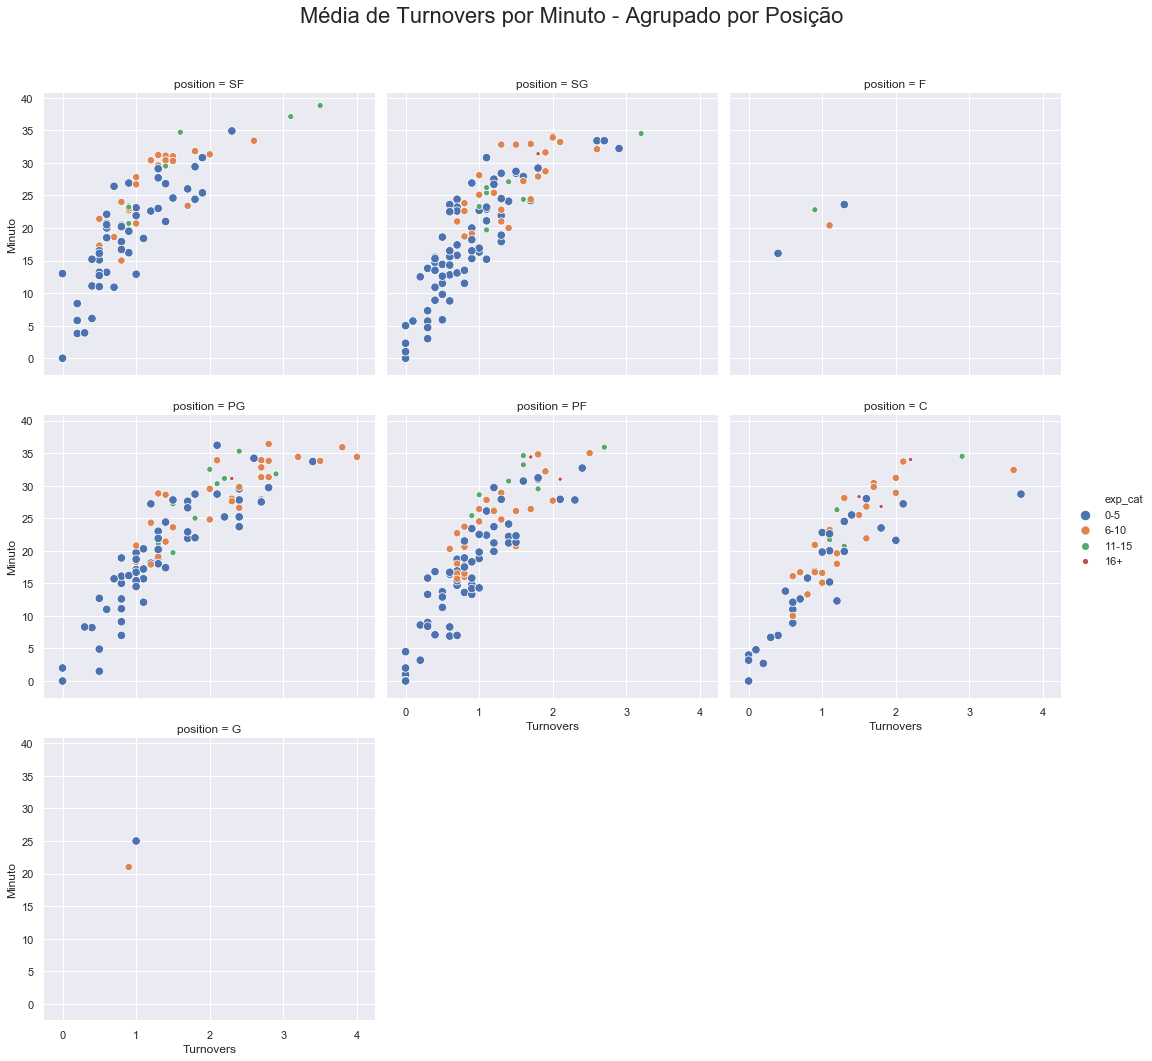

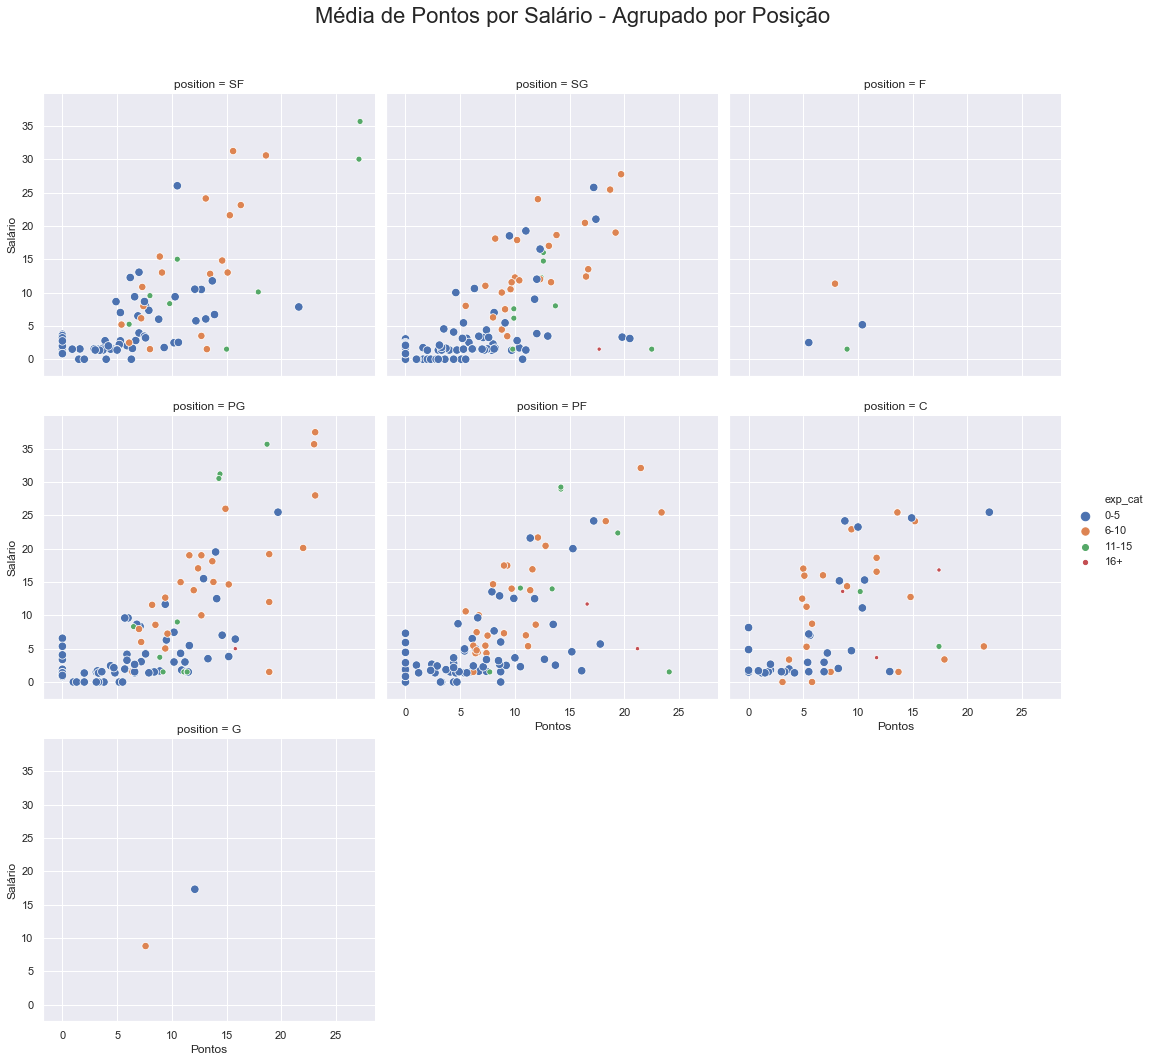

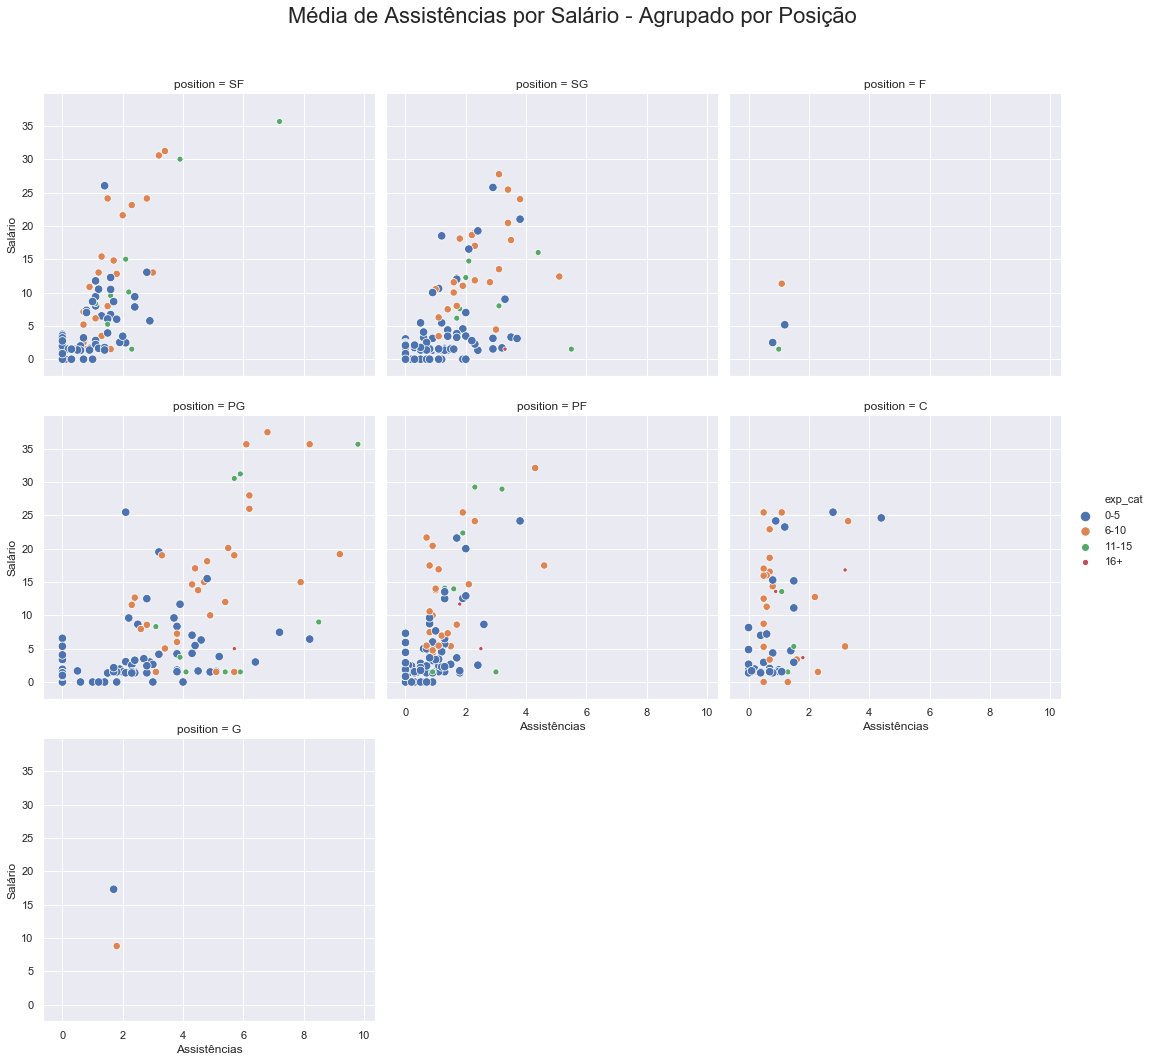

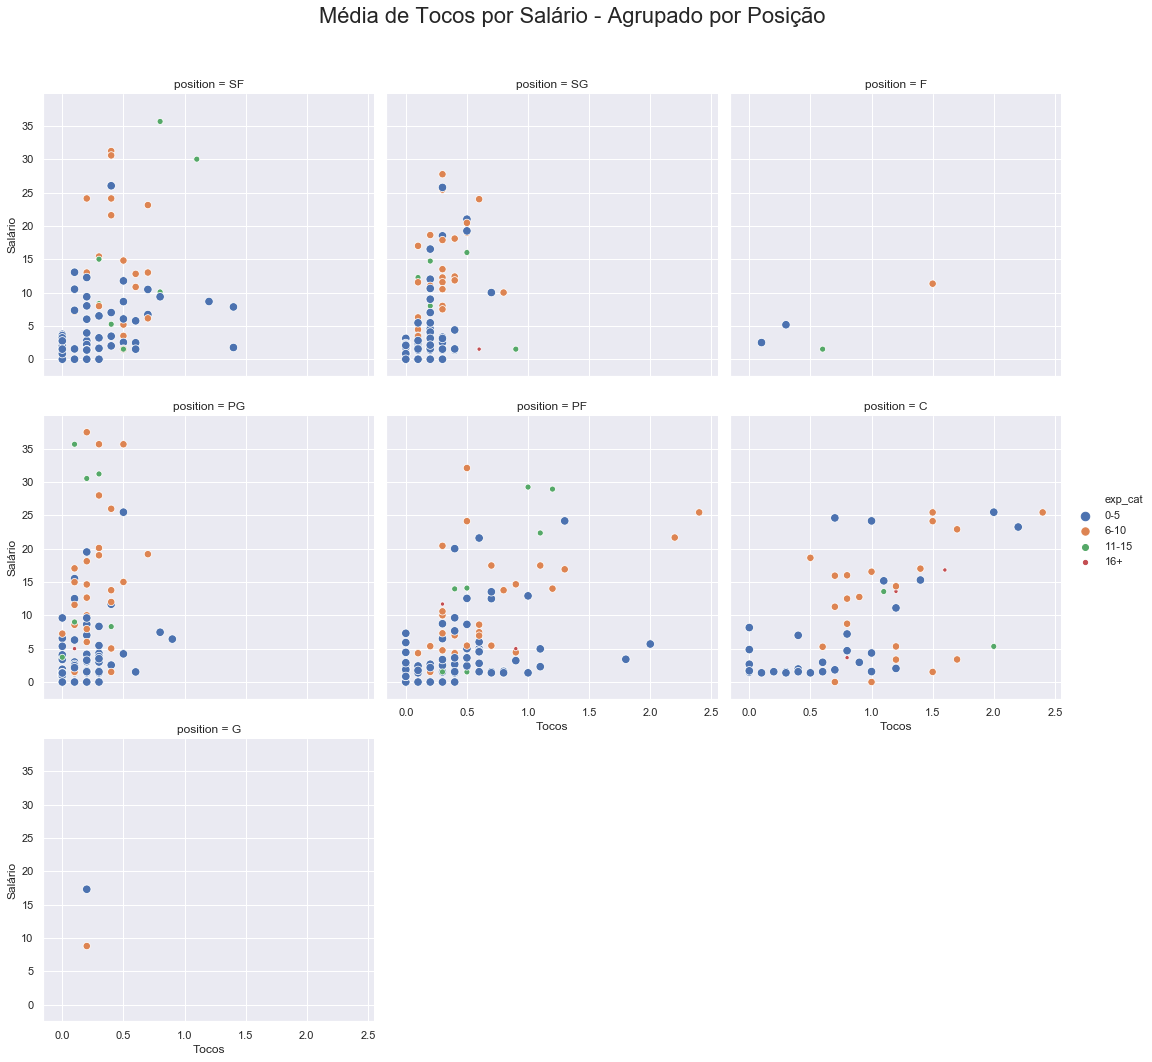

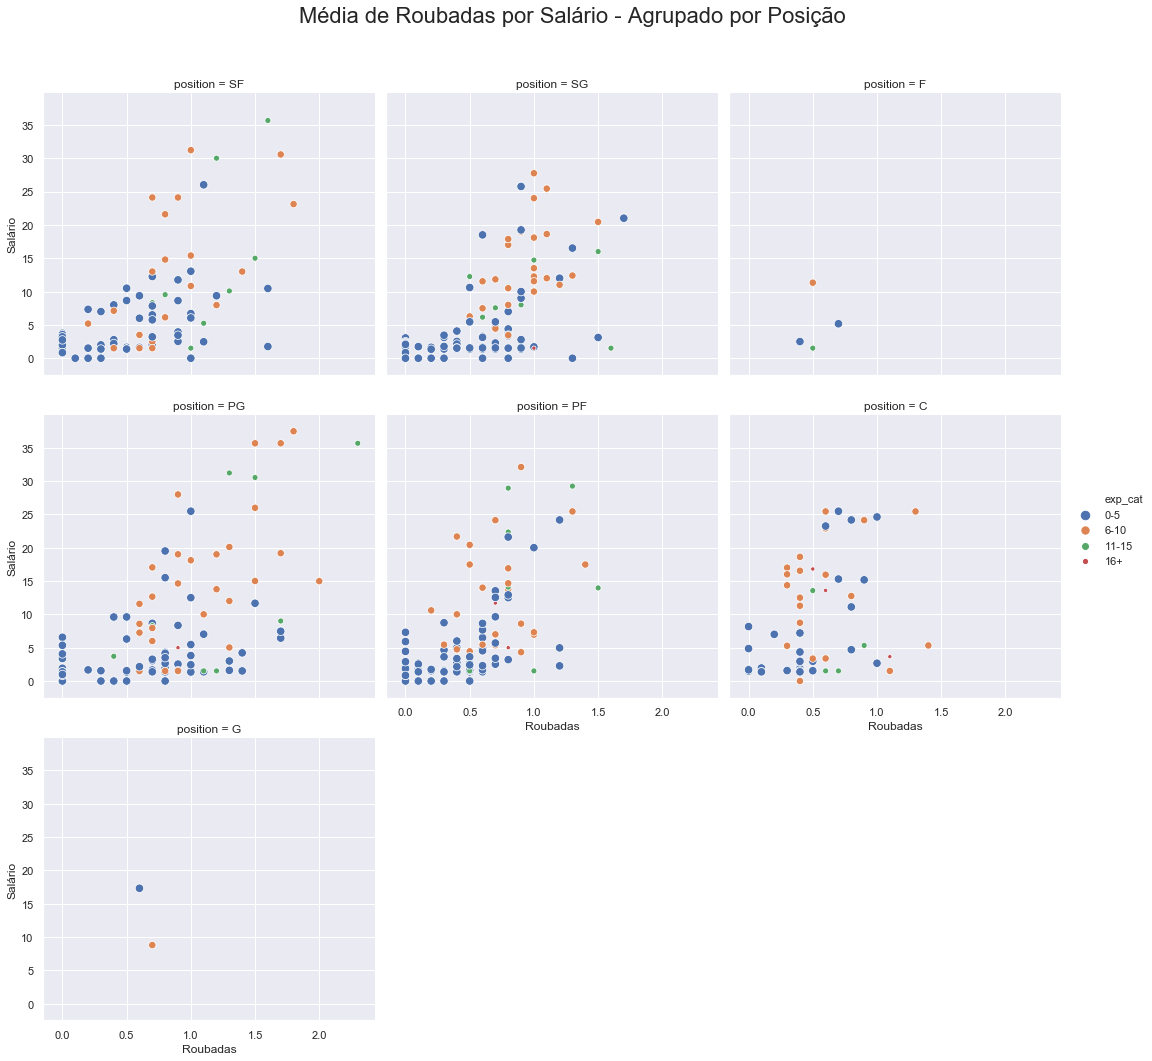

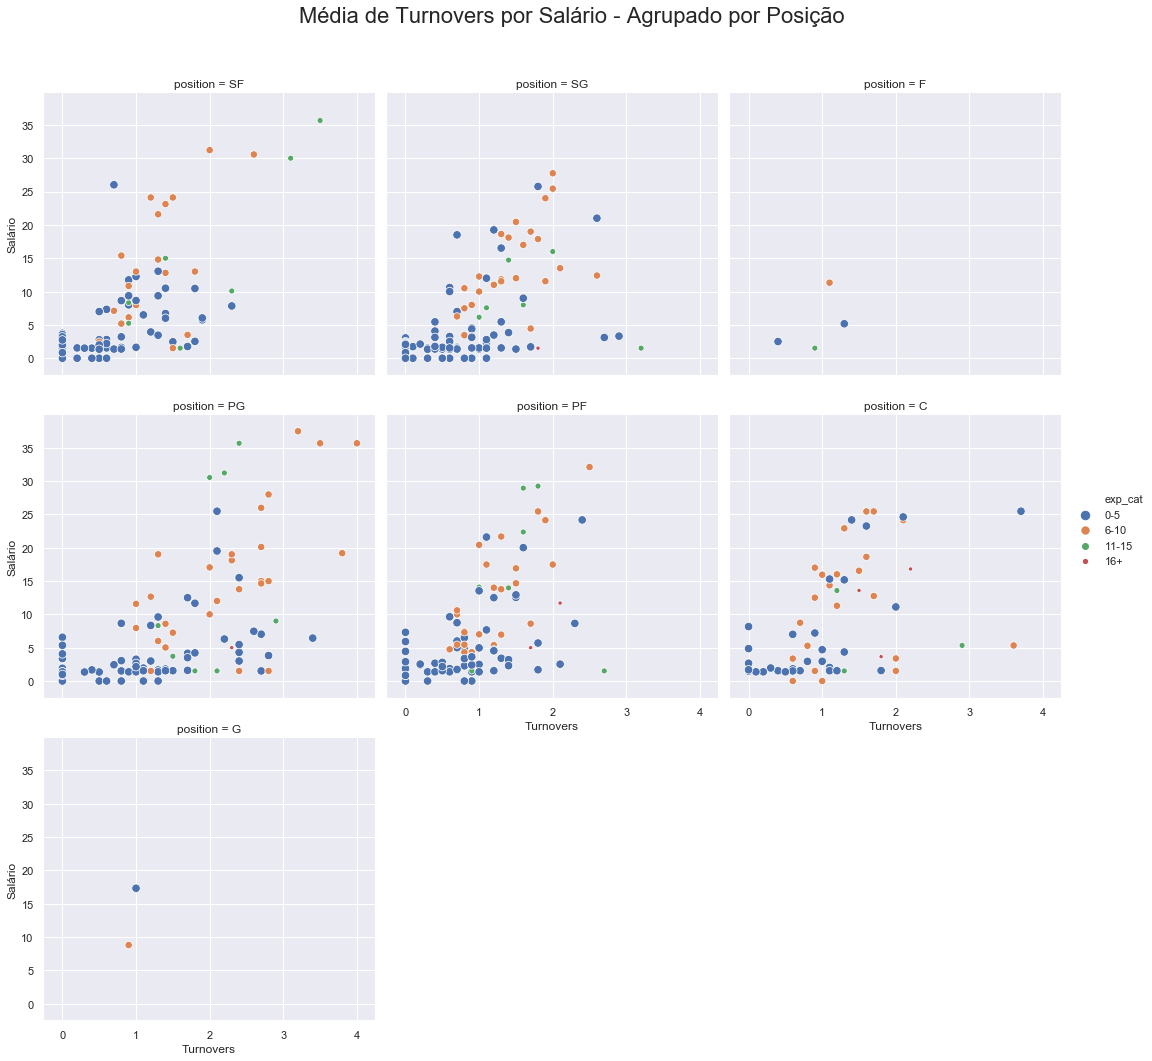

In [707]:
kinds = ['mpg', 'salary']
kinds_name = ['Minuto', 'Salário']

attrs = ['ppg', 'apg', 'blkpg', 'stlpg', 'topg']
attrs_name = ['Pontos', 'Assistências', 'Tocos', 'Roubadas', 'Turnovers']

for kind, kName in zip(kinds, kinds_name):
    for attr, aName in zip(attrs, attrs_name):
        stats_grouped_by_position_chart(nba, attr, aName, kind, kName)

In [815]:
def hightest_salary_per_position_by_team_heatmap(df):
    # Removendo as posições G e F que são poucas
    nba_5pos = df.loc[(df['position'] != 'G') & (nba['position'] != 'F')]
    
    # ids dos jogadores com maior salario por posição por time
    nba_hghst_salary = nba_5pos.groupby(['team', 'position'])['salary'].idxmax().tolist()
    data = nba_5pos.loc[nba_hghst_salary]
    nba_salary_table = pd.pivot_table(data, values='salary', index='team', columns=['position'])

    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_title('Maior Salário por Posição Por Time (Milhão)')
    
    sns.heatmap(nba_salary_table, cmap="seismic", linewidth=.7,
                robust=True, annot=True, annot_kws={'size': 13})

    ax.set_xlabel('Posição')
    ax.set_ylabel('Time')

In [832]:
def mean_salary_per_position_by_team_heatmap(df):
    # Removendo as posições G e F que são poucas
    nba_5pos = df.loc[(df['position'] != 'G') & (df['position'] != 'F')]
    nba_mean_table = pd.pivot_table(nba_5pos, values='salary', 
                                    index='team', columns=['position'],
                                    aggfunc=np.mean)

    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_title('Média de Salário por Posição Por Time (Milhão)')
    
    sns.heatmap(nba_mean_table, cmap="seismic", linewidth=.7,
                robust=True, annot=True, annot_kws={'size': 13})

    ax.set_xlabel('Posição')
    ax.set_ylabel('Time')

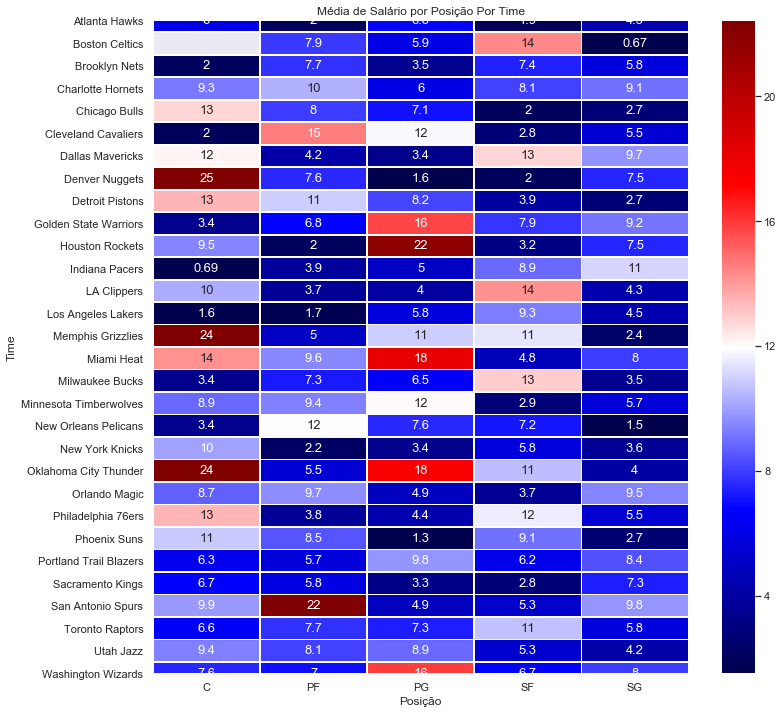

In [833]:
mean_salary_per_position_by_team_heatmap(nba)

In [838]:
def top20_salaries(df):
    idx = df['salary'].sort_values(ascending=False)[:20].index
    return nba.loc[idx, ['team', 'name', 'salary', 'position', 'age', 'mpg', 'ppg', 'apg', 'stlpg', 'topg']]

top20_salaries(nba)

,team,name,salary,position,age,mpg,ppg,apg,stlpg,topg
103,Golden State Warriors,Stephen Curry,37.457154,PG,30,34.4,23.1,6.8,1.8,3.2
147,Los Angeles Lakers,LeBron James,35.654150,SF,33,38.8,27.2,7.2,1.6,3.5
310,Houston Rockets,Chris Paul,35.654150,PG,33,35.3,18.7,9.8,2.3,2.4
510,Oklahoma City Thunder,Russell Westbrook,35.654150,PG,29,34.4,23.0,8.2,1.7,4.0
306,Houston Rockets,James Harden,35.650150,PG,29,33.8,23.0,6.1,1.5,3.5
230,Detroit Pistons,Blake Griffin,32.088932,PF,29,35.0,21.5,4.3,0.9,2.5
6,Boston Celtics,Gordon Hayward,31.214295,SF,28,31.3,15.6,3.4,1.0,2.0
89,Toronto Raptors,Kyle Lowry,31.200000,PG,32,31.1,14.4,5.9,1.3,2.2
502,Oklahoma City Thunder,Paul George,30.560700,SF,28,33.4,18.6,3.2,1.7,2.6
320,Memphis Grizzlies,Mike Conley,30.521115,PG,31,32.5,14.3,5.7,1.5,2.0
